In [2]:
# Reference: https://jupyterbook.org/interactive/hiding.html
# Use {hide, remove}-{input, output, cell} tags to hiding content

import sys
import os
if not any(path.endswith('textbook') for path in sys.path):
    sys.path.append(os.path.abspath('../../..'))
from textbook_utils import *

# Basics of Hypothesis Testing

A hypothesis test can offer support for your model, and it can help formally refute some other understanding of the world. There are four basic steps to hypothesis testing:

1. Set up: You have your data, and you want to test whether a particular model is reasonably consistent with the data. So, you specify a statistic, $\hat{\theta}$, such as the sample average, fraction of zeros in a sample, or fitted regression coefficient, with the goal of comparing your data's statistic to what might have been produced under the model.

1. Model: You spell out the model that you want to test in the form of a data generation mechanism, along with any specific assumptions about the population. This model typically includes specifying $\theta^*$, which may be the population mean, the proportion of zeros, or a regression coefficient. The sampling distribution of the statistic under this model is referred to as the null distribution, and the model itself is called the *Null Hypothesis*.

3. Compute: How likely, according to the null model in Step 2, is it to get data (and the resulting statistic) at least as extreme as what you actually got in Step 1?  In formal inference, this probability is called the $p$-*value*. To approximate the $p$-value, we often use the computer to generate a large number of repeated random trials using the assumptions in the model and find the fraction of samples that give a value of the statistic at least as extreme as our observed value. At other times we use mathematical theory to find the $p$-value.
  
4. Interpret: The p-value is used as a measure of surprise.  If the model that you spelled out in Step 2 is believable, how surprised should you be to get the data (and summary statistic) that you actually got?  A moderate sized p-value means that the observed statistic is pretty much what you would expect to get for data generated by the null model.  A tiny p-value raises doubts about the null model. In other words, if the model is correct (or approximately correct), then it would be very unusual to get such an extreme value of the test statistic for data generated by the model.  In this case, either the null model is wrong or a very unlikely outcome has occurred. Statistical logic says to conclude that the pattern is real; that it is more than just coincidence.  Then, it's up to you to explain why the data generation process led to such an unusual value. This is when a careful consideration of the scope is important. 

Let's demonstrate these steps in the testing process with a few examples. 

## Example: A Rank-test to Compare Productivity of Wikipedia Contributors 

Recall the Wikipedia example from {numref}`Chapter %s <ch:data_scope>`, where a randomly selected set of 200 contributors were chosen from among the top 1\% of contributors who were active in the past 30 days on the English-language Wikipedia and who had never receive an informal  "barnstar" award.  These 200 contributors were divided at random into two groups of 100. The contributors in one group, the treatment group, were each awarded a barnstar, while no one in the other group was given an award. All 200 contributors were followed for 90 days and their activity on Wikipedia recorded. 

It has been conjectured that informal awards have a reinforcing effect on volunteer work, and this experiment was designed to formally study this conjecture. We will carry out a hypothesis test based on the rankings of the data. 

We begin by reading the data into a data frame.

In [22]:
wiki = pd.read_csv("data/Wikipedia.csv")
wiki.shape

(200, 2)

In [23]:
wiki.describe()[3:]

,experiment,postproductivity
min,0.0,0.0
25%,0.0,57.5
50%,0.5,250.5
75%,1.0,608.0
max,1.0,2344.0


The data frame has 200 rows, one for each contributor. The feature `experiment` is either 0 or 1, depending on whether the contributor was in the control or treatment group, respectively; and `postproductivity` is a count of the edits made by the contributor in the 90 days after the barnstars were awarded. The gap between the quartiles (lower, middle, and upper) suggest the distribution of productivity is highly skewed. We make a histogram to confirm.

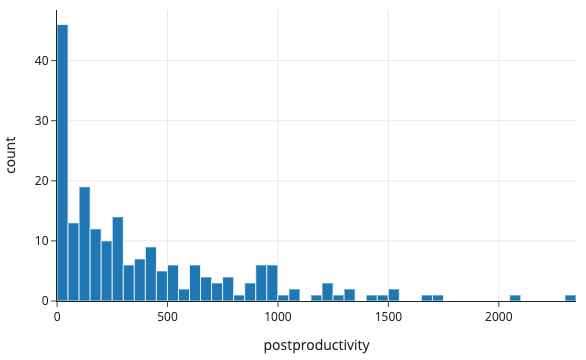

In [27]:
px.histogram(wiki, x='postproductivity', nbins=50,
             width=350, height=250)

Indeed, the histogram of post-award productivity is highly skewed, with a spike near zero. The skewness suggests a statistics based on the ordering of the values from the two samples.  

To compute our statistic, we order all productivity values from smallest to largest. The smallest value has rank 1, the second smallest rank 2, and so on up to the largest value which has a rank of 200. We use these ranks to compute our statistic, $\hat{\theta}$, which is the average rank of the treatment group. We chose this statistic because it is insensitive to highly skewed distributions. For example, whether the largest value is 700 or 700,000, it still receives the same rank, namely 200. If the informal award incentivizes contributors, then we would expect the average rank of the treatment group to be typically higher than the control. 

The null model assumes that an informal award has *no* effect on productivity and any difference observed between the treatment and control groups is due to the chance process in assigning contributors to groups. The Null Hypothesis is set up for the status quo to be rejected; that is, we hope to find a surprise in assuming no effect. 

The Null Hypothesis assumes the ranks for productivity for the treatment group should be like 100 draws from an urn with 200 marbles, marked 1, 2, 3, ..., 200. In this case, the average rank would be $(1 + 200)/2 = 100.5$ 

We use the `rankdata` method in `scipy.stats` to rank the 200 values and compute the sum of ranks in the treatment group.

In [29]:
from scipy.stats import rankdata
ranks = rankdata(wiki['postproductivity'], 'average')

Let's confirm that the average rank of the 200 values is 100.5.

In [30]:
np.average(ranks)

100.5

And, find the average rank of the 100 productivity scores in the treatment group:

In [31]:
np.average(ranks[100:])

113.68

The average rank in the treatment group is higher than expected. We can use simulation to find the sampling distribution for this statistic to see if 113 is a routine value or a surprising one. 

To carry out this simulation, we set up the urn as the `ranks` array from the data. Shuffling the 200 values in the array and taking the first 100 represents a randomly sampled treatment group. We write a function to shuffle the array of ranks and find the average of the first 100.

In [32]:
def rank_avg(ranks, n):
    rng.shuffle(ranks)
    return np.average(ranks[n:])      

Our simulation shuffles the "marbles in the urn" 100,000 times and computes the average rank for each shuffle.

In [33]:
rng = np.random.default_rng(42)
rank_avg_simulation = [rank_avg(ranks, 100) for _ in range(100000)] 

Text(0.5, 0, 'Average Rank for treatment')

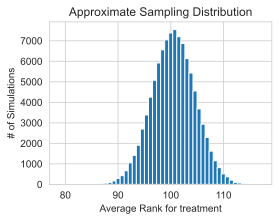

In [34]:
plt.hist(rank_avg_simulation, bins=50)
plt.title('Approximate Sampling Distribution')
plt.ylabel('# of Simulations')
plt.xlabel('Average Rank of the Treatment Group')

As we expected, the sampling distribution of the average rank is centered on 100 (100.5 actually) and is bell-shaped. This center of this distribution reflects the assumptions of the treatment having no effect. Our observed statistic looks well outside the typical range of simulated average ranks, and we use this simulated sampling distribution to find the approximate $p$-value for observing a statistic at least as big as ours.

In [35]:
len([elem for elem in rank_avg_simulation if elem >= 113.68]) / 100000

0.00052

This is a big surprise. Under the null, the chance of seeing an average rank at least as large as ours is about 5 in 10,000. 

This test raises doubt about the null model. Statistical logic has us conclude that the pattern is real. How do we interpret this? The experiment was well designed. The 200 contributors were selected at random from the top 1% and then they were divided at random into two groups. These chance processes say that we can rely on the sample of 200 being representative of top contributors, and the treatment and control groups being similar to each other in every way except for the application of the treatment. Given the careful design, we conclude that informal awards have a positive effect on productivity for top contributors.

Although, we carried out a simulation to find the $p$-value for our observed statistic, rank tests are commonly used and made available in most statistical software. 

In [36]:
from scipy.stats import ranksums

ranksums(x=treatment['postproductivity'], y=control['postproductivity'])

RanksumsResult(statistic=3.220386553232206, pvalue=0.0012801785007519996)

The $p$-value here is twice the $p$-value we computed because we considered only values greater than the observed, whereas the `ranksums` test computed the the $p$-value for both sides of the distribution. In our example, we are only interested in an increase in productivity, and so use a one-sided $p$-value, which is half the reported value above (0.0006) and close to our simulated value.

This somewhat unusual test statistic that uses ranks, rather than the actual data values, was developed in the 1950s and 1960s, before today's era of powerful laptop computers. The mathematical properties of rank statistics is well developed and the sampling distribution is well behaved (it is symmetric and shaped like the bell curve even for small data sets). However, rank tests are still used today in A/B testing where samples tend to be highly skewed and it is common to carry out many, many tests.

This is because the ranks maintain order, but remove skewness from the data, so the sum of random ranks has an approximate normal distribution for sums of ranks for samples of as few as 20 to 30 values. While, we have simply simulated the approximate sampling distribution of the rank-sum and not used this normal property of the sampling distribution, it was originally designed as a statistics because of this useful property, and today, when conducting hundreds and thousands of A/B tests, many of which have skewed empirical distributions, tests based on ranks are still popular.

The next example, revisits the vaccine efficacy example from {numref}`Chapter %s <ch:theory_datadesign>`. There, we encountered a hypothesis test without actually calling it that.  

## Example: A test of proportions for vaccine efficacy

Recall the randomized clinical trial of the J\&J vaccine ({numref}`Chapter %s <ch:theory_datadesign>`), where 43,738 people enrolled in the trial, were randomly split into equal groups, and the treatment group was administered the vaccine while the control group was given a fake vaccine, called a placebo. Over the next month, 117 people in the treatment group fell ill, and 351 in the control group. 

We want to compare the proportion of sick individuals in each group. To do this, we use vaccine efficacy, 

$$ \hat{\theta} = \frac {\hat{p}_{C} - \hat{p}_T} {\hat{p}_C} = 1 - \frac {\hat{p}_T} {\hat{p}_C}, $$

Where $\hat{p}_{C}$ and $\hat{p}_T$ are the observed proportion of sick people in the control and treatment groups, respectively. The observed value of vaccine efficacy in the J\&J trial is,

$$ 1 - \frac{117/21869} {351/21869} 
   = 1- \frac{117}{351} = 0.667$$


The CDC set a standard of 50% for vaccine efficacy, meaning that the efficacy has to exceed 50% to be approved for distribution. The null model assumes that vaccine efficacy is 50% ($\theta^* = 0.5$, and any difference of the observed value from the expected is due to the chance process in assigning people to groups. Again, we set the Null hypothesis as the status quo that the vaccine isn't effective enough to warrant approval, and we hope to find a surprise and reject the Null. 

With a little algebra, the null model $0.5 = 1 - p_T / p_C$ reduces to $p_T = 0.5 p_C$.  That is, the null hypothesis implies the proportion of ill people among those receiving the treatment is at most half that of the control. Notice that the actual values for the two risks ($p_T$ and $p_C$) are not assumed in the null.  That is, the model doesn't assume the treatment doesn't work, rather that its efficacy is no larger than 0.5. 

Our urn model in this situation is a bit different than what we set up in {numref}`Chapter %s <ch:theory_datadesign>`.  The urn still has 43,738 marbles in it, corresponding to the enrolless in the experiment. But now, each marble has two numbers on it, which for simplicity appear in a pair, such as $(0, 1)$. The number on the left is the response if the person receives the treatment, and the number on the right corresponds to the response to no treatment (the control). As usual, 1 means they become ill, and 0 means they stay healthy. 

The null model assumes that the proportion of ones on the left of the pair is half the proportion on the right. Since we don't know these two proportions, we can use the data to estimate them. There are three types of marbles in the urn $(0,0)$, $(0,1)$ and $(1, 1)$. We assume that $(1, 0)$, which corresponds to a person getting ill under treatment and not under control, is not possible.  We observed 351 people getting sick in control and 117 in treatment. With the assumption that the treatment rate of illness is  half that of the control, we can tray a few scenarios. For example, we can study the case where 117 people in treatment didn't get sick, but would have if in control so all combined 585 people would get the virus if they didn't receive the vaccine, and half of these would not get the virus if they received treatment. Table {numref}vacc-urn shows these counts.  

:::{table} Vaccine Trial Urn
:name: vacc-urn

| Label   | Count  |
|---------|--------|
| (0, 0)  | 43,152 |
| (0, 1   |    293 |
| (1, 0)  |      0 |
| (1, 1)  |    293 |
|Total    | 43,738 |

:::

We can use these counts to carry out a simulation of the clinical trial and compute vaccine efficacy. As shown in {numref}`Chapter %s <ch:>` the multivariate hypergeometric function simulates draws from an urn when there are more than two kinds of marbles.
We set this urn and sampling process up here.

In [27]:
N = 43738
n_samp = 21869
N_groups = np.array([293, 293, (N-586)])

from scipy.stats import multivariate_hypergeom

def vacc_eff(N_groups, n_samp):
    treat = multivariate_hypergeom.rvs(N_groups, n_samp)
    ill_t = treat[1]
    ill_c = N_groups[0] - treat[0] + N_groups[1] - treat[1]
    return (ill_c - ill_t) / ill_c

Now, we can simulate the clinical trial 100,000 times and calculate the vaccine efficacy for each trial.

In [28]:
sim_vacc_eff = [vacc_eff(N_groups, n_samp) for _ in range(100000)] 

Text(0.5, 0, 'Vaccine Efficacy')

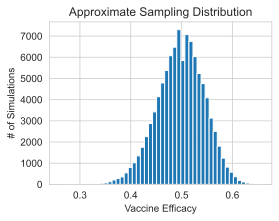

In [29]:
plt.hist(sim_vacc_eff, bins=50)
#plt.axvline(0.57, color='red', linestyle='dashed', linewidth=2)
plt.title('Approximate Sampling Distribution')
plt.ylabel('# of Simulations')
plt.xlabel('Vaccine Efficacy')

In [30]:
len([elem for elem in sim_vacc_eff_2 if elem >= 0.666]) 

1

Just one of the 100,000 simulations had a vaccine efficacy as large as the observed 0.667. This is a rare event, and that's why the CDC approved the Johnson & Johnson vaccine for distribution.  

In this example of hypothesis testing, we were not able to completely specify the model and we had to provide approximate values for $p_C$ and $p_T$ based on our observed values of $\hat{p}_C$ and $\hat{p}_T$. At times the null model isn't entirely specified, and we must rely on the data to set up the model. 
The next section introduces a general approach, called the bootstrap, to approximate the model using the data.